In [1]:
import json
from collections import Counter
from pathlib import Path

import google.generativeai as genai
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from tqdm.auto import tqdm
from how_to_sample.ed import estimate_ED

# Load spaCy model for embeddings
nlp = spacy.load("en_core_web_md")

In [ ]:
GEMINI_API_KEY = "API_KEY_HERE"

# Load keywords and preprocess / match to concrete nouns

In [2]:
with open(
    "outputs/get_image_keywords/image_keywords.json",
    "r",
) as f:
    image_keywords = json.load(f)

In [3]:
n_unique_keywords = len(np.unique(np.concatenate([v for v in image_keywords.values()])))
print(f"Number of unique keywords: {n_unique_keywords}")

Number of unique keywords: 75535


In [4]:
concrete_nouns = pd.read_excel(
    "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/7_get_image_keywords/concrete_Nouns.xlsx"
)
concrete_nouns = concrete_nouns[concrete_nouns["Conc.M"] > 4]
concrete_nouns = concrete_nouns["Word"].values

print(f"Number of concrete nouns: {len(concrete_nouns)}")

Number of concrete nouns: 8095


In [5]:
subtlex_word_frequencies = pd.read_excel(
    "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/7_get_image_keywords/SUBTLEXusfrequencyabove1.xls"
)

In [6]:
concrete_noun_frequencies = subtlex_word_frequencies[
    subtlex_word_frequencies["Word"].isin(concrete_nouns)
]
concrete_nouns = concrete_noun_frequencies["Word"].values

print(f"Number of concrete nouns with frequency available: {len(concrete_nouns)}")

Number of concrete nouns with frequency available: 5256


In [7]:
from joblib import Parallel, delayed


def filter_keywords(item):
    k, v = item
    return k, [word for word in v if word in concrete_nouns]


# Using all available cores (-1) since we're on a powerful machine
image_keywords = dict(
    Parallel(n_jobs=32)(
        delayed(filter_keywords)(item) for item in tqdm(image_keywords.items())
    )
)

print(
    f"Number of unique keywords after filtering: {len(np.unique(np.concatenate([v for v in image_keywords.values()])))}"
)
filtered_noun_frequencies = subtlex_word_frequencies[
    subtlex_word_frequencies["Word"].isin(
        np.unique(np.concatenate([v for v in image_keywords.values()]))
    )
]
print(
    f"Number of concrete nouns with frequency available after filtering: {len(filtered_noun_frequencies)}"
)

  0%|          | 0/99994 [00:00<?, ?it/s]

Number of unique keywords after filtering: 3563
Number of concrete nouns with frequency available after filtering: 3563


In [8]:
# get unique keywords and how often each keyword appears
keyword_counts = {}
for cluster_id, keywords in image_keywords.items():
    for keyword in keywords:
        keyword_counts[keyword] = keyword_counts.get(keyword, 0) + 1

sorted_keyword_counts = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
sorted_keyword_counts = pd.DataFrame(
    sorted_keyword_counts, columns=["keyword", "count"]
)
sorted_keyword_counts.head()

keyword  count
0      woman  10264
1  landscape   9383
2     people   8003
3   building   7593
4      house   7474

# Test how different sampling strategies affect distribution of concepts

In [9]:
result_fps = Path("outputs/get_image_keyword_subsets").glob("*.npy")

sampling_results = {}
for result_fp in result_fps:
    sampling_strategy = result_fp.stem.replace("selected_indices_", "").replace(
        ".npy", ""
    )
    result = np.load(result_fp)
    sampling_results[sampling_strategy] = result

In [10]:
baseline_counter = Counter()
for key, keywords in image_keywords.items():
    baseline_counter.update(keywords)

sampling_counters = {}
for strategy, indices in sampling_results.items():
    counter = Counter()
    for idx in indices:
        key_str = str(idx)  # Convert the integer index to string.
        if key_str in image_keywords:  # Only use indices that exist in image_keywords.
            counter.update(image_keywords[key_str])
    sampling_counters[strategy] = counter

In [11]:
wf_counter = Counter(
    dict(zip(filtered_noun_frequencies["Word"], filtered_noun_frequencies["FREQcount"]))
)


# Utility function for normalization of counts.
def normalize_counter(counter):
    total = sum(counter.values())
    if total == 0:
        return {k: 0 for k in counter}
    return {k: v / total for k, v in counter.items()}


baseline_norm = normalize_counter(baseline_counter)
sampling_norm = {
    strategy: normalize_counter(counter)
    for strategy, counter in sampling_counters.items()
}
word_freq_norm = normalize_counter(wf_counter)

In [12]:
ordered_words = [word for word, _ in wf_counter.most_common()]

In [13]:
x = np.arange(len(ordered_words))
baseline_vals = np.array([baseline_norm.get(word, 0) for word in ordered_words])
word_freq_vals = np.array([word_freq_norm.get(word, 0) for word in ordered_words])
sampling_vals = {}
for strategy, norm_dict in sampling_norm.items():
    sampling_vals[strategy] = np.array(
        [norm_dict.get(word, 0) for word in ordered_words]
    )

## Aggregating keywords and comparing frequency distributions

In [14]:
from collections import defaultdict


# First, create semantic categories using HDBSCAN on word embeddings
def create_semantic_categories(words, nlp, n_categories=None, min_cluster_size=5):
    """
    Create semantic categories from words using HDBSCAN clustering on word embeddings.
    Returns category labels and the mapping of words to categories.
    """
    # Get word embeddings
    word_vectors = np.array([nlp(word).vector for word in words])

    # Cluster using HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=1,
        cluster_selection_method="eom",
        prediction_data=True,
    )
    cluster_labels = clusterer.fit_predict(word_vectors)

    # Get the n_categories most populous clusters
    label_counts = Counter(cluster_labels)
    top_clusters = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[
        :n_categories
    ]
    valid_clusters = {label for label, _ in top_clusters}

    # Create mapping of words to clusters
    word_to_cluster = {}
    cluster_words = defaultdict(list)

    for word, label in zip(words, cluster_labels):
        if label in valid_clusters:
            word_to_cluster[word] = label
            cluster_words[label].append(word)

    # Name categories based on most frequent words in each cluster
    category_names = {}
    for label in valid_clusters:
        # Get top 3 most frequent words in cluster
        cluster_word_freq = [(w, baseline_counter[w]) for w in cluster_words[label]]
        top_words = sorted(cluster_word_freq, key=lambda x: x[1], reverse=True)[:3]
        category_names[label] = "/".join(w for w, _ in top_words)

    return category_names, word_to_cluster

  0%|          | 0/6 [00:00<?, ?it/s]

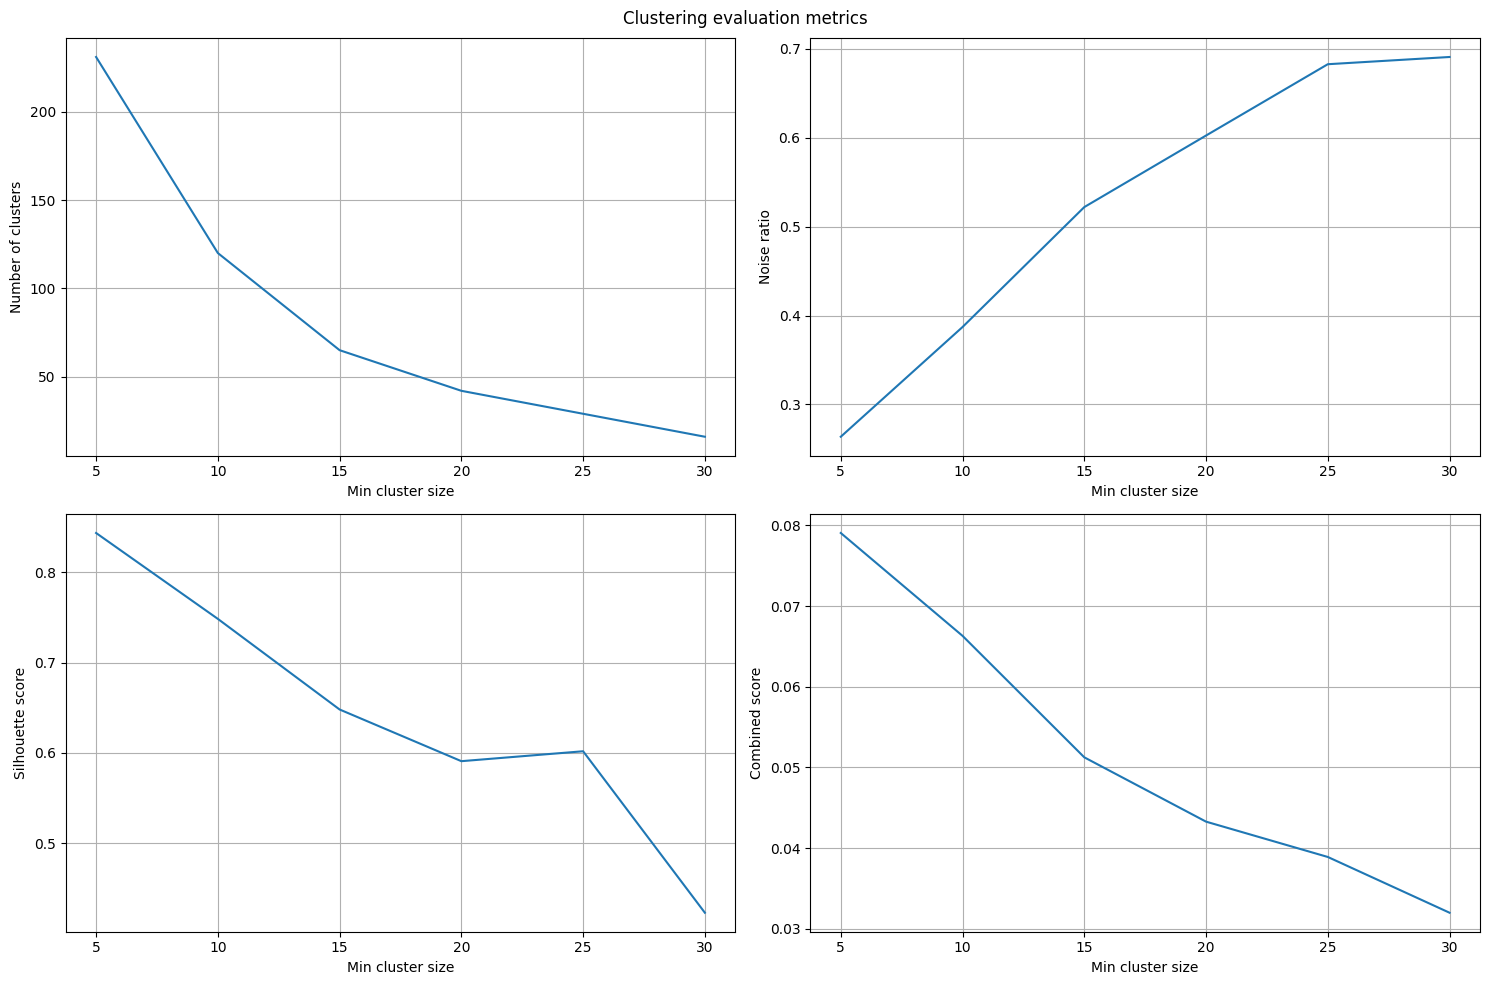


Optimal min_cluster_size: 5
Number of clusters: 231
Noise ratio: 26.35%


In [15]:
import warnings

from sklearn.metrics import silhouette_score


def find_optimal_clustering(words, nlp, min_size_range=range(5, 35, 5)):
    """
    Find optimal clustering parameters for HDBSCAN by evaluating different min_cluster_sizes.

    Args:
        words: List of words to cluster
        nlp: Loaded spacy model
        min_size_range: Range of min_cluster_size values to try

    Returns:
        optimal_min_size: Best min_cluster_size value
        optimal_labels: Cluster labels for optimal clustering
        metrics: Dictionary with evaluation metrics
    """
    # Get word embeddings
    word_vectors = np.array([nlp(word).vector for word in words])

    best_score = -np.inf
    optimal_min_size = None
    optimal_labels = None
    metrics = []

    for min_size in tqdm(min_size_range):
        # Cluster with current parameters
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_size,
            min_samples=1,
            cluster_selection_method="eom",
            prediction_data=True,
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            cluster_labels = clusterer.fit_predict(word_vectors)

        # Skip if all points are noise
        if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
            continue

        # Calculate metrics
        n_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))
        noise_ratio = np.mean(cluster_labels == -1)

        # Calculate silhouette score only for non-noise points
        non_noise_mask = cluster_labels != -1
        if np.sum(non_noise_mask) > 1:
            sil_score = silhouette_score(
                word_vectors[non_noise_mask], cluster_labels[non_noise_mask]
            )
        else:
            sil_score = -1

        # Combine metrics into a single score
        # We want: high silhouette, low noise ratio, reasonable number of clusters
        combined_score = sil_score * (1 - noise_ratio) * (1 / np.log2(n_clusters + 1))

        metrics.append(
            {
                "min_cluster_size": min_size,
                "n_clusters": n_clusters,
                "noise_ratio": noise_ratio,
                "silhouette": sil_score,
                "combined_score": combined_score,
            }
        )

        if combined_score > best_score:
            best_score = combined_score
            optimal_min_size = min_size
            optimal_labels = cluster_labels

    # Plot evaluation metrics
    metrics_df = pd.DataFrame(metrics)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Clustering evaluation metrics")

    axes[0, 0].plot(metrics_df["min_cluster_size"], metrics_df["n_clusters"])
    axes[0, 0].set_ylabel("Number of clusters")
    axes[0, 0].grid(True)

    axes[0, 1].plot(metrics_df["min_cluster_size"], metrics_df["noise_ratio"])
    axes[0, 1].set_ylabel("Noise ratio")
    axes[0, 1].grid(True)

    axes[1, 0].plot(metrics_df["min_cluster_size"], metrics_df["silhouette"])
    axes[1, 0].set_ylabel("Silhouette score")
    axes[1, 0].grid(True)

    axes[1, 1].plot(metrics_df["min_cluster_size"], metrics_df["combined_score"])
    axes[1, 1].set_ylabel("Combined score")
    axes[1, 1].grid(True)

    for ax in axes.flat:
        ax.set_xlabel("Min cluster size")

    plt.tight_layout()
    plt.show()

    return optimal_min_size, optimal_labels, metrics_df


# Find optimal parameters
optimal_min_size, optimal_labels, metrics_df = find_optimal_clustering(
    ordered_words, nlp
)
print(f"\nOptimal min_cluster_size: {optimal_min_size}")
print(f"Number of clusters: {len(np.unique(optimal_labels[optimal_labels != -1]))}")
print(f"Noise ratio: {np.mean(optimal_labels == -1):.2%}")

In [16]:
# Create categories
category_names, word_to_cluster = create_semantic_categories(
    ordered_words, nlp, min_cluster_size=optimal_min_size
)


# Aggregate values for each category
def aggregate_by_category(values, words, word_to_cluster):
    category_values = defaultdict(float)
    category_counts = defaultdict(int)

    for word, value in zip(words, values):
        if word in word_to_cluster:
            category = word_to_cluster[word]
            category_values[category] += value
            category_counts[category] += 1

    # Average the values in each category
    return {cat: val / category_counts[cat] for cat, val in category_values.items()}


# Prepare category-level data
category_data = {}
category_data["Total dataset"] = aggregate_by_category(
    baseline_vals, ordered_words, word_to_cluster
)
category_data["Word frequency"] = aggregate_by_category(
    word_freq_vals, ordered_words, word_to_cluster
)
for strategy, vals in sampling_vals.items():
    category_data[strategy] = aggregate_by_category(
        vals, ordered_words, word_to_cluster
    )

# Prepare data for radar plot
categories = sorted(category_names.keys())
category_labels = [category_names[cat] for cat in categories]

radar_data = {}
for name, cat_values in category_data.items():
    radar_data[name] = [cat_values[cat] for cat in categories]

In [17]:
genai.configure(api_key=GEMINI_API_KEY)

generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
}


def get_cost(response):
    input_token_price = 0.0375 / 1e6
    output_token_price = 0.15 / 1e6
    input_tokens = response.usage_metadata.prompt_token_count
    output_tokens = response.usage_metadata.candidates_token_count
    return input_tokens * input_token_price + output_tokens * output_token_price


model = genai.GenerativeModel(
    model_name="gemini-1.5-flash-8b",
    generation_config=generation_config,
)


def get_category_label(words):
    """Get a descriptive label for a category of words using Gemini API."""
    prompt = f"""Here is a list of words that belong to the same semantic category:
{", ".join(words)}

What would be a good, concise (1-3 words) label for this category (be relatively specific)? 
Return ONLY the label, nothing else."""

    response = model.generate_content(prompt)
    return response


# Process each category
semantic_labels = {}
total_cost = 0

for label in tqdm(categories):
    # Get all words for this category
    category_words = [
        word
        for word in ordered_words
        if word in word_to_cluster and word_to_cluster[word] == label
    ]

    try:
        response = get_category_label(category_words)
        semantic_labels[label] = response.text.strip()

        # Track cost if needed
        cost = get_cost(response)  # You'll need to implement this based on your needs
        total_cost += cost

    except Exception as e:
        print(f"Error processing category {label}: {e}")
        # Fallback to original naming scheme
        cluster_word_freq = [(w, baseline_counter[w]) for w in category_words]
        top_words = sorted(cluster_word_freq, key=lambda x: x[1], reverse=True)[:3]
        semantic_labels[label] = "/".join(w for w, _ in top_words)

print(f"Total cost: ${total_cost:.2f}")

# Update the radar plot with new labels
category_labels = [semantic_labels[cat] for cat in categories]

  0%|          | 0/232 [00:00<?, ?it/s]

Total cost: $0.00


In [18]:
category_words = {}
for label in categories:
    category_words[label] = [
        word
        for word in ordered_words
        if word in word_to_cluster and word_to_cluster[word] == label
    ]

In [19]:
def compute_kl_divergence(p, q, epsilon=1e-10):
    """
    Compute KL divergence between two distributions.
    Add small epsilon to avoid log(0).

    Args:
        p: First distribution
        q: Second distribution (reference)
        epsilon: Small value to avoid numerical issues
    """
    # Ensure arrays are numpy arrays
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon

    # Normalize to ensure proper probability distributions
    p = p / p.sum()
    q = q / q.sum()

    return np.sum(p * np.log(p / q))

In [20]:
image_features = np.load(
    "outputs/get_LAION_image_keywords/features.npy"
)

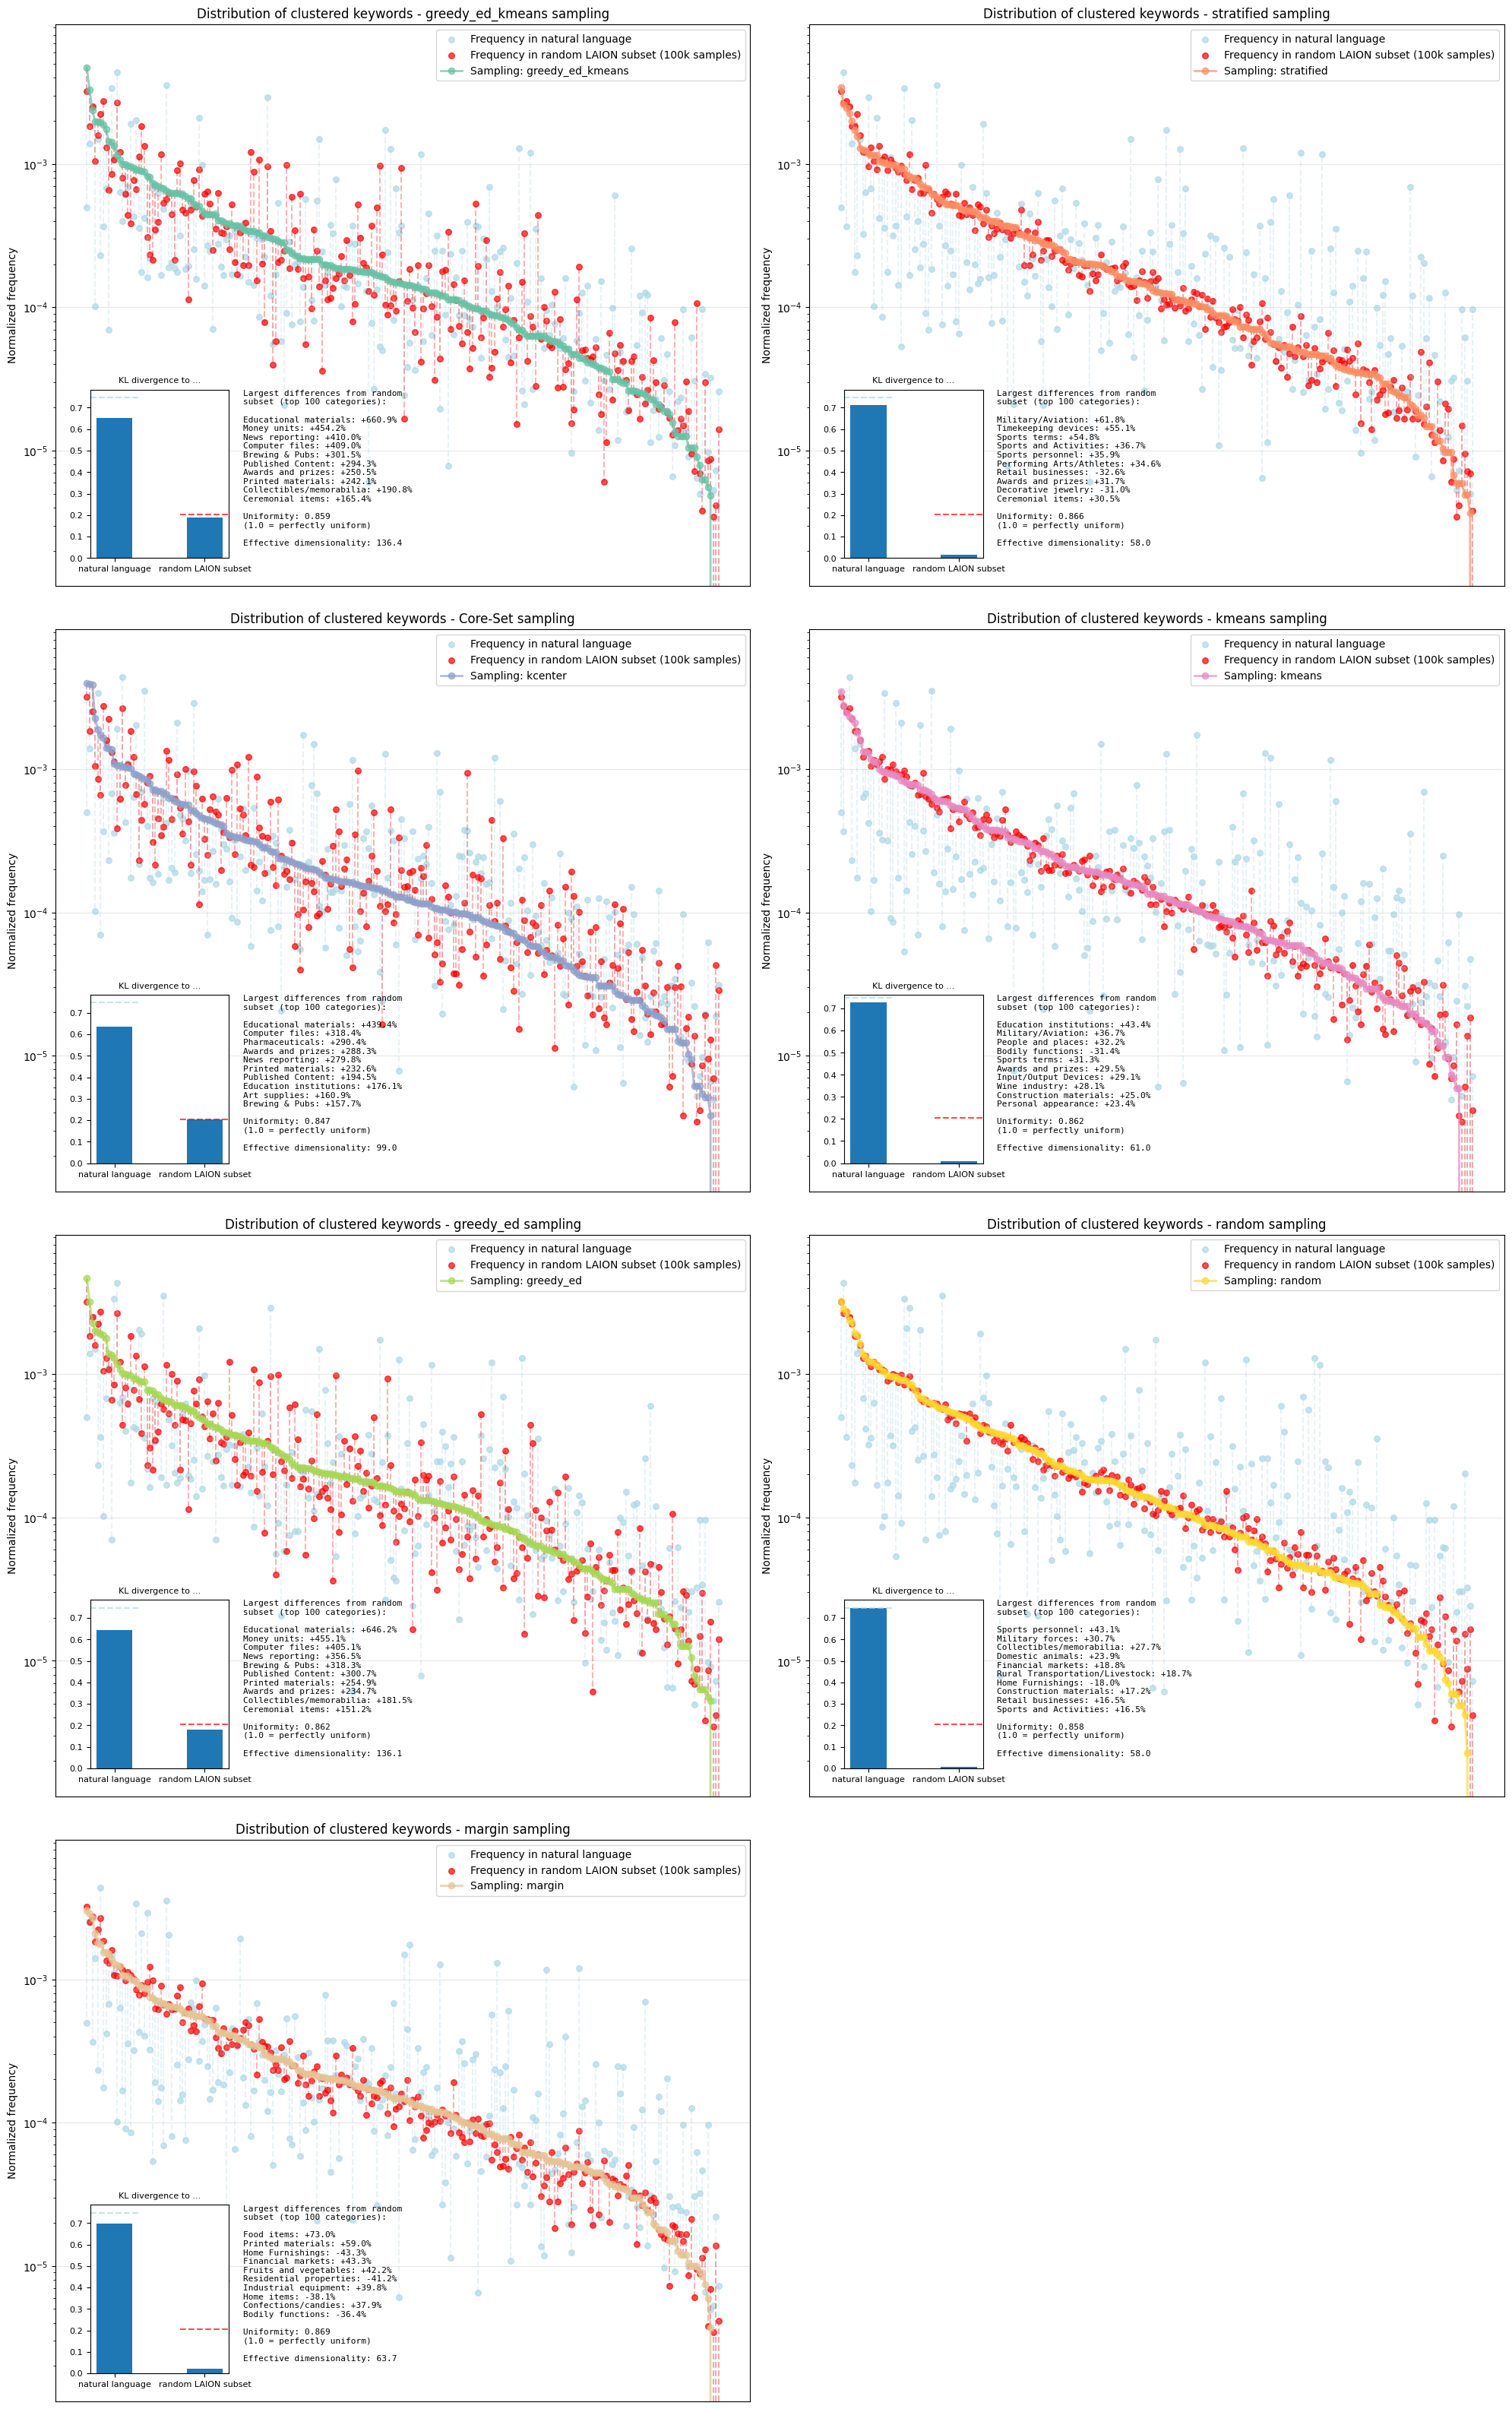

In [21]:
# Prepare data for plotting
n_strategies = len(sampling_vals)
n_cols = 2  # You can adjust this
n_rows = (n_strategies + n_cols - 1) // n_cols

# Calculate max KL divergences across all strategies
max_kl_wf = max(
    compute_kl_divergence(
        np.array([category_data[strat][cat] for cat in categories]),
        np.array([category_data["Word frequency"][cat] for cat in categories]),
    )
    for strat in sampling_vals
)

max_kl_total = max(
    compute_kl_divergence(
        np.array([category_data[strat][cat] for cat in categories]),
        np.array([category_data["Total dataset"][cat] for cat in categories]),
    )
    for strat in sampling_vals
)

all_vals = []
for strategy in sampling_vals:
    strategy_vals = [category_data[strategy][cat] for cat in categories]
    wf_vals = [category_data["Word frequency"][cat] for cat in categories]
    total_vals = [category_data["Total dataset"][cat] for cat in categories]
    all_vals.extend(strategy_vals + wf_vals + total_vals)

global_min = min(v for v in all_vals if v > 0)  # Exclude zeros for log scale
global_max = max(all_vals)

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8 * n_rows))
axes = axes.flatten()

# Plot each sampling strategy in its own subplot
for i, (strategy, values) in enumerate(sampling_vals.items()):
    ax = axes[i]

    # Create inset axes for bar plot and text box
    inset_ax = ax.inset_axes([0.05, 0.05, 0.2, 0.3])
    text_ax = ax.inset_axes([0.27, 0.05, 0.3, 0.3])
    text_ax.axis("off")

    # Sort categories based on current sampling strategy's values
    strategy_values = [category_data[strategy][cat] for cat in categories]
    sort_idx = np.argsort(strategy_values)[::-1]
    sorted_categories = [categories[i] for i in sort_idx]
    sorted_labels = [category_labels[i] for i in sort_idx]

    # Set up x-axis positions
    index = np.arange(len(categories))

    # Get values for each distribution
    wf_vals = [category_data["Word frequency"][cat] for cat in sorted_categories]
    total_vals = [category_data["Total dataset"][cat] for cat in sorted_categories]
    strategy_vals = [category_data[strategy][cat] for cat in sorted_categories]

    # Plot vertical lines connecting points
    for idx, (wf, total, strat) in enumerate(zip(wf_vals, total_vals, strategy_vals)):
        # Plot vertical line to word frequency
        ax.vlines(idx, strat, wf, colors="lightblue", linestyles="--", alpha=0.3)
        # Plot vertical line to total dataset
        ax.vlines(idx, strat, total, colors="red", linestyles="--", alpha=0.3)

    # Plot markers for reference distributions
    ax.scatter(
        index,
        wf_vals,
        color="lightblue",
        alpha=0.7,
        label="Frequency in natural language",
        marker="o",
        s=30,
    )
    ax.scatter(
        index,
        total_vals,
        color="red",
        alpha=0.7,
        label="Frequency in random LAION subset (100k samples)",
        marker="o",
        s=30,
    )

    # Plot sampling strategy line
    ax.plot(
        index,
        strategy_vals,
        marker="o",
        color=plt.cm.Set2(i / n_strategies),
        alpha=0.7,
        label=f"Sampling: {strategy}",
        linewidth=2,
    )

    # Customize the main subplot
    ax.set_xlabel("")
    ax.set_ylabel("Normalized frequency")
    ax.set_title(
        f"Distribution of clustered keywords - {strategy if strategy != 'kcenter' else 'Core-Set'} sampling"
    )
    ax.set_xticks([])
    ax.set_yscale("log")
    ax.set_ylim(global_min * 0.5, global_max * 2)  # Add some padding
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")

    # Inset bar plot code
    strategy_dist = np.array([category_data[strategy][cat] for cat in categories])
    word_freq_dist = np.array(
        [category_data["Word frequency"][cat] for cat in categories]
    )
    total_dist = np.array([category_data["Total dataset"][cat] for cat in categories])

    kl_to_word_freq = compute_kl_divergence(strategy_dist, word_freq_dist)
    kl_to_total = compute_kl_divergence(strategy_dist, total_dist)

    bar_x = [0, 1]
    bar_heights = [kl_to_word_freq, kl_to_total]

    inset_ax.bar(bar_x, bar_heights, width=0.4)
    inset_ax.axhline(
        y=max_kl_wf, xmin=0, xmax=0.35, color="lightblue", linestyle="--", alpha=0.7
    )
    inset_ax.axhline(
        y=max_kl_total, xmin=0.65, xmax=1, color="red", linestyle="--", alpha=0.7
    )

    inset_ax.set_xticks(bar_x)
    inset_ax.set_xticklabels(["natural language", "random LAION subset"], fontsize=8)
    inset_ax.set_title("KL divergence to ...", fontsize=8)
    inset_ax.tick_params(axis="both", which="major", labelsize=8)

    # Calculate uniformity metric using normalized entropy
    probs = np.array(strategy_vals)
    probs = probs / probs.sum()  # Ensure normalization
    entropy = -np.sum(
        probs * np.log(probs + 1e-10)
    )  # Add small epsilon to avoid log(0)
    max_entropy = np.log(
        len(categories)
    )  # Maximum possible entropy (uniform distribution)
    uniformity = entropy / max_entropy  # Normalize to [0, 1] range

    # Get top 100 most frequent categories in the strategy
    top_100_idx = np.argsort(strategy_vals)[-100:]

    # Calculate percentage differences between strategy and total dataset
    # ((strategy - total) / total) * 100
    pct_diffs = (
        (np.array(strategy_vals)[top_100_idx] - np.array(total_vals)[top_100_idx])
        / np.array(total_vals)[top_100_idx]
        * 100
    )

    # Get indices of top 10 largest absolute differences
    largest_diff_idx = np.argsort(np.abs(pct_diffs))[-10:][::-1]

    # Get corresponding categories and values
    diff_categories = [sorted_labels[top_100_idx[i]] for i in largest_diff_idx]
    diff_pcts = [pct_diffs[i] for i in largest_diff_idx]

    # Calculate ED for this sampling strategy
    strategy_features = image_features[sampling_results[strategy]]
    ed = estimate_ED(strategy_features)

    # Update text content to include ED
    text_content = "Largest differences from random\nsubset (top 100 categories):\n\n"
    for cat, pct_diff in zip(diff_categories, diff_pcts):
        direction = "+" if pct_diff > 0 else "-"
        text_content += f"{cat}: {direction}{abs(pct_diff):.1f}%\n"

    text_content += f"\nUniformity: {uniformity:.3f}"
    text_content += "\n(1.0 = perfectly uniform)"
    text_content += f"\n\nEffective dimensionality: {ed:.1f}"

    text_ax.text(
        0, 1, text_content, verticalalignment="top", fontsize=8, fontfamily="monospace"
    )

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(
    "/home/jroth/controversial_stimuli/experiments/laion/embedding_space/notebooks/outputs/7_compare_concept_distributions/distribution_changes_per_sampling_strategy.pdf",
    dpi=300,
)
plt.show()

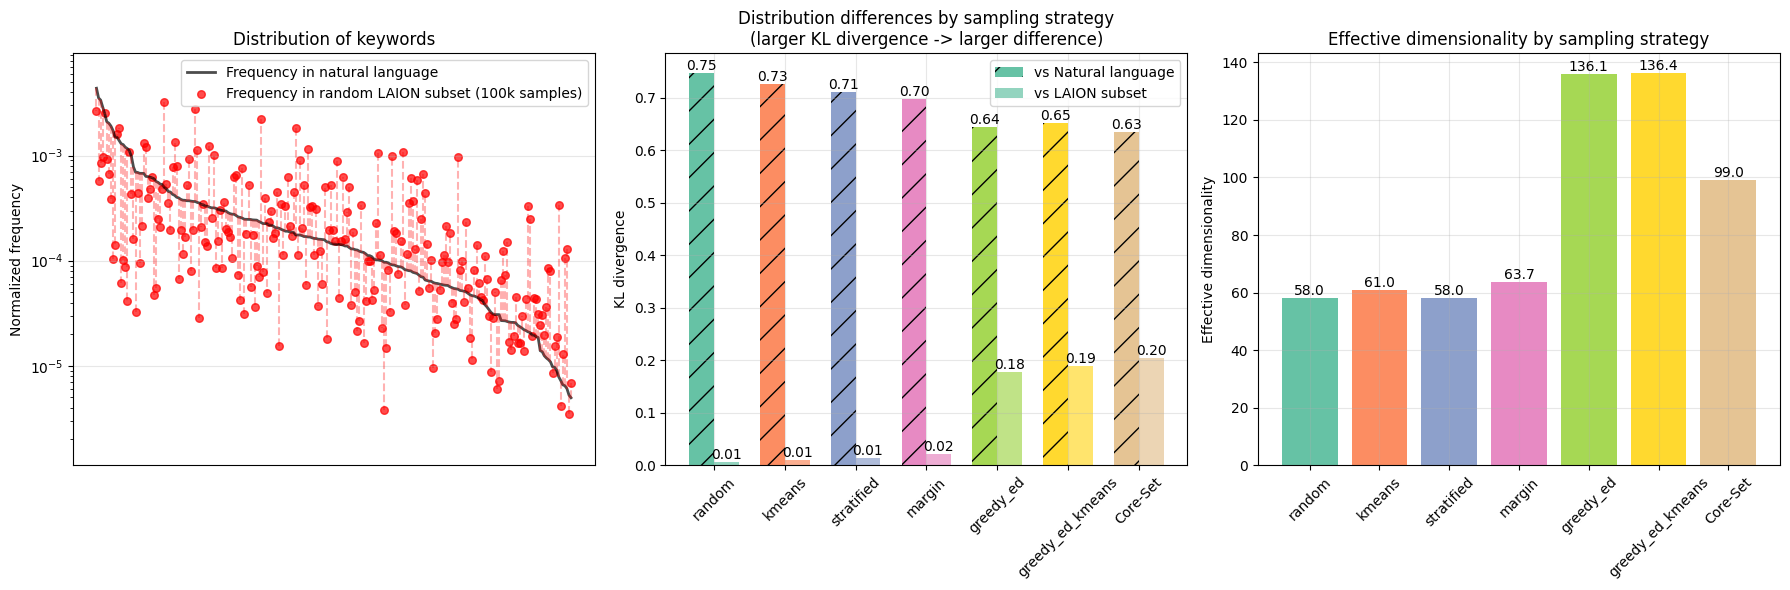

In [23]:
# Create figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Sort categories based on word frequency values
wf_vals = [category_data["Word frequency"][cat] for cat in categories]
sort_idx = np.argsort(wf_vals)[::-1]
sorted_categories = [categories[i] for i in sort_idx]
sorted_labels = [category_labels[i] for i in sort_idx]

# Get sorted values
index = np.arange(len(categories))
wf_vals = [category_data["Word frequency"][cat] for cat in sorted_categories]
total_vals = [category_data["Total dataset"][cat] for cat in sorted_categories]

# Left plot: Distribution comparison
# Plot natural language frequency as main line
ax1.plot(
    index,
    wf_vals,
    color="black",
    alpha=0.7,
    label="Frequency in natural language",
    linewidth=2,
)

# Plot LAION subset as dots with vertical lines
ax1.scatter(
    index,
    total_vals,
    color="red",
    alpha=0.7,
    s=30,
    label="Frequency in random LAION subset (100k samples)",
)
ax1.vlines(index, wf_vals, total_vals, colors="red", linestyles="--", alpha=0.3)

# Customize left plot
ax1.set_xlabel("")
ax1.set_ylabel("Normalized frequency")
ax1.set_title("Distribution of keywords")
ax1.set_xticks([])
ax1.set_yscale("log")
ax1.set_ylim(global_min * 0.5, global_max * 2)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="upper right")

# Middle plot: KL divergences
strategies = [s for s in sampling_vals.keys() if s != "oracle"]  # Exclude oracle
# strategies = list(sampling_vals.keys())
n_strategies = len(strategies)

# Compute KL divergences for each strategy
strategy_metrics = []
for strategy in strategies:
    strategy_dist = np.array([category_data[strategy][cat] for cat in categories])
    word_freq_dist = np.array(
        [category_data["Word frequency"][cat] for cat in categories]
    )
    total_dist = np.array([category_data["Total dataset"][cat] for cat in categories])

    kl_to_wf = compute_kl_divergence(strategy_dist, word_freq_dist)
    kl_to_total = compute_kl_divergence(strategy_dist, total_dist)

    # Compute ED for this strategy
    strategy_features = image_features[sampling_results[strategy]]
    ed = estimate_ED(strategy_features)

    strategy_metrics.append(
        {
            "strategy": strategy,
            "kl_to_wf": kl_to_wf,
            "kl_to_total": kl_to_total,
            "ed": ed,
        }
    )

# Sort strategies by KL divergence to LAION subset, then by natural language
strategy_metrics.sort(key=lambda x: (x["kl_to_total"], x["kl_to_wf"]))
strategies = [m["strategy"] for m in strategy_metrics]
kl_to_wf = [m["kl_to_wf"] for m in strategy_metrics]
kl_to_total = [m["kl_to_total"] for m in strategy_metrics]
eds = [m["ed"] for m in strategy_metrics]

# Create grouped bar plot for KL divergences
x = np.arange(len(strategies))
bar_width = 0.35

bars1 = ax2.bar(
    x - bar_width / 2,
    kl_to_wf,
    bar_width,
    label="vs Natural language",
    color=[plt.cm.Set2(strategies.index(s) / n_strategies) for s in strategies],
    hatch="/",
)
bars2 = ax2.bar(
    x + bar_width / 2,
    kl_to_total,
    bar_width,
    label="vs LAION subset",
    color=[plt.cm.Set2(strategies.index(s) / n_strategies) for s in strategies],
    alpha=0.7,
)

# Customize middle plot
ax2.set_ylabel("KL divergence")
ax2.set_title(
    "Distribution differences by sampling strategy\n(larger KL divergence -> larger difference)"
)
ax2.set_xticks(x)
ax2.set_xticklabels(
    [s if s != "kcenter" else "Core-Set" for s in strategies], rotation=45
)
ax2.legend()
ax2.grid(True, alpha=0.3)


# Add value labels on KL divergence bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            rotation=0,
        )


autolabel(bars1)
autolabel(bars2)

# Right plot: Effective dimensionality
bars3 = ax3.bar(
    x, eds, color=[plt.cm.Set2(strategies.index(s) / n_strategies) for s in strategies]
)

# Customize right plot
ax3.set_ylabel("Effective dimensionality")
ax3.set_title("Effective dimensionality by sampling strategy")
ax3.set_xticks(x)
ax3.set_xticklabels(
    [s if s != "kcenter" else "Core-Set" for s in strategies], rotation=45
)
ax3.grid(True, alpha=0.3)

# Add value labels on ED bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        rotation=0,
    )

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(
    "/home/jroth/controversial_stimuli/experiments/laion/embedding_space/notebooks/outputs/7_compare_concept_distributions/distribution_changes_summary.pdf"
)
plt.show()

In [24]:
import os
import pickle
import numpy as np

output_dir = "outputs/compare_concept_distributions"
output_filename = "plotting_data.pkl"
output_filepath = os.path.join(output_dir, output_filename)

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory set to: {output_dir}")

required_vars = [
    "categories",
    "category_labels",
    "category_data",
    "global_min",
    "global_max",
    "image_features",
    "sampling_results",
    "sampling_vals",
]

proceed_with_saving = True
for var_name in required_vars:
    if var_name not in globals():
        print(
            f"Error: Variable '{var_name}' is not defined in the global scope. Please ensure it is available."
        )
        proceed_with_saving = False
        break

if proceed_with_saving:
    data_to_save = {
        "categories": categories,
        "category_labels": category_labels,
        "category_data": category_data,
        "global_min": global_min,
        "global_max": global_max,
        "image_features": image_features,
        "sampling_results": sampling_results,
        "sampling_vals": sampling_vals,
    }

    # --- Save data to pickle file ---
    with open(output_filepath, "wb") as f:
        pickle.dump(data_to_save, f)

    print(f"Successfully saved plotting data to: {output_filepath}")
    print("\n--- How to load the data later ---")
    print("You can load the data back using the following snippet:")
    print(f"""
import pickle

# Make sure to use the same filepath you saved to:
# output_filepath_to_load = "{output_filepath}" # Or define it as above

# with open(output_filepath_to_load, "rb") as f:
#     loaded_data = pickle.load(f)

# # Unpack the variables
# categories = loaded_data["categories"]
# category_labels = loaded_data["category_labels"]
# category_data = loaded_data["category_data"]
# global_min = loaded_data["global_min"]
# global_max = loaded_data["global_max"]
# image_features = loaded_data["image_features"]
# sampling_results = loaded_data["sampling_results"]
# sampling_vals = loaded_data["sampling_vals"]

# print("Data loaded successfully.")
# # Now you can re-run your plotting code using these loaded variables.
# # Ensure helper functions like compute_kl_divergence and estimate_ED are also defined.
    """)
else:
    print("Data saving aborted due to missing variables.")

Output directory set to: /home/jroth/controversial_stimuli/experiments/laion/embedding_space/notebooks/outputs/7_compare_concept_distributions
Successfully saved plotting data to: /home/jroth/controversial_stimuli/experiments/laion/embedding_space/notebooks/outputs/7_compare_concept_distributions/plotting_data.pkl

--- How to load the data later ---
You can load the data back using the following snippet:

import pickle

# Make sure to use the same filepath you saved to:
# output_filepath_to_load = "/home/jroth/controversial_stimuli/experiments/laion/embedding_space/notebooks/outputs/7_compare_concept_distributions/plotting_data.pkl" # Or define it as above

# with open(output_filepath_to_load, "rb") as f:
#     loaded_data = pickle.load(f)

# # Unpack the variables
# categories = loaded_data["categories"]
# category_labels = loaded_data["category_labels"]
# category_data = loaded_data["category_data"]
# global_min = loaded_data["global_min"]
# global_max = loaded_data["global_max"]
# i

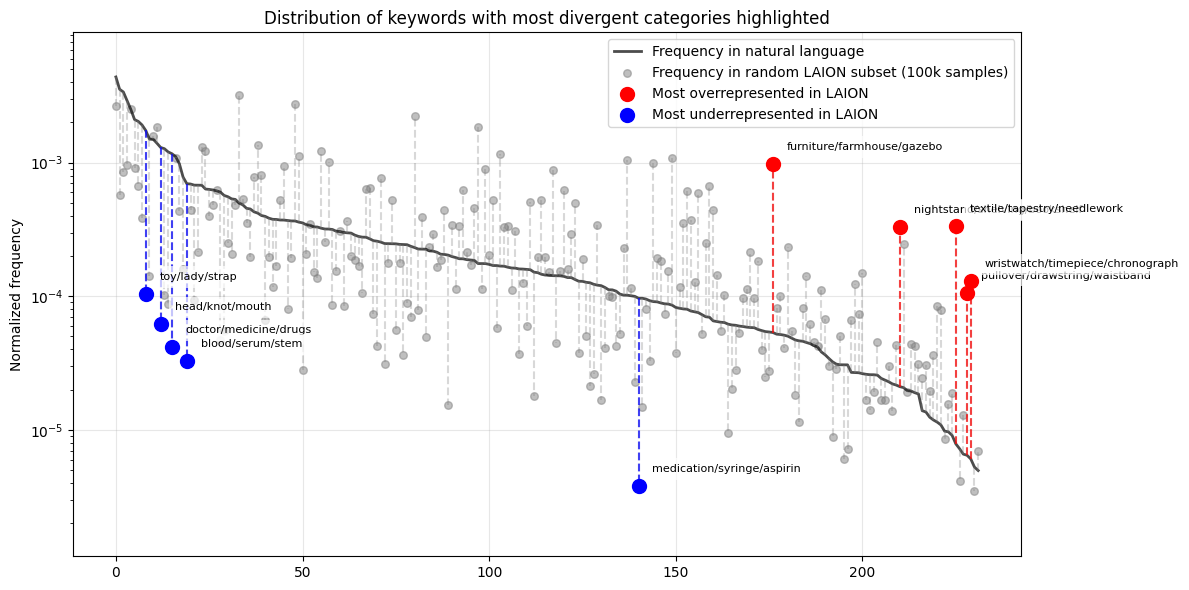


Most overrepresented categories in LAION (relative to natural language):
textile/tapestry/needlework: 42.7x more frequent
wristwatch/timepiece/chronograph: 21.4x more frequent
furniture/farmhouse/gazebo: 18.3x more frequent
pullover/drawstring/waistband: 16.5x more frequent
nightstand/shelving/bookshelf: 15.7x more frequent

Most underrepresented categories in LAION (relative to natural language):
doctor/medicine/drugs: 28.1x less frequent
medication/syringe/aspirin: 25.4x less frequent
blood/serum/stem: 21.3x less frequent
head/knot/mouth: 20.9x less frequent
toy/lady/strap: 16.7x less frequent


In [172]:
# Create figure
plt.figure(figsize=(12, 6))

# Sort categories based on word frequency values
wf_vals = [category_data["Word frequency"][cat] for cat in categories]
sort_idx = np.argsort(wf_vals)[::-1]
sorted_categories = [categories[i] for i in sort_idx]
sorted_labels = [category_labels[i] for i in sort_idx]

# Get sorted values
index = np.arange(len(categories))
wf_vals = [category_data["Word frequency"][cat] for cat in sorted_categories]
total_vals = [category_data["Total dataset"][cat] for cat in sorted_categories]

# Calculate relative differences
relative_diffs = np.array(total_vals) / np.array(wf_vals)
top_over_idx = np.argsort(relative_diffs)[-5:]  # Top 5 overrepresented
top_under_idx = np.argsort(relative_diffs)[:5]  # Top 5 underrepresented

# Plot natural language frequency as main line
plt.plot(
    index,
    wf_vals,
    color="black",
    alpha=0.7,
    label="Frequency in natural language",
    linewidth=2,
)

# Plot LAION subset as dots with vertical lines
plt.scatter(
    index,
    total_vals,
    color="gray",
    alpha=0.5,
    s=30,
    label="Frequency in random LAION subset (100k samples)",
)
plt.vlines(index, wf_vals, total_vals, colors="gray", linestyles="--", alpha=0.3)

# Highlight overrepresented categories in red
plt.scatter(
    np.array(index)[top_over_idx],
    np.array(total_vals)[top_over_idx],
    color="red",
    s=100,
    label="Most overrepresented in LAION",
    zorder=5,
)
plt.vlines(
    index[top_over_idx],
    [wf_vals[i] for i in top_over_idx],
    [total_vals[i] for i in top_over_idx],
    colors="red",
    linestyles="--",
    alpha=0.7,
)

# Highlight underrepresented categories in blue
plt.scatter(
    np.array(index)[top_under_idx],
    np.array(total_vals)[top_under_idx],
    color="blue",
    s=100,
    label="Most underrepresented in LAION",
    zorder=5,
)
plt.vlines(
    index[top_under_idx],
    [wf_vals[i] for i in top_under_idx],
    [total_vals[i] for i in top_under_idx],
    colors="blue",
    linestyles="--",
    alpha=0.7,
)

# Add annotations for highlighted points
for idx in np.concatenate([top_over_idx, top_under_idx]):
    plt.annotate(
        sorted_labels[idx],
        (index[idx], total_vals[idx]),
        xytext=(10, 10),
        textcoords="offset points",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        fontsize=8,
    )

plt.xlabel("")
plt.ylabel("Normalized frequency")
plt.title("Distribution of keywords with most divergent categories highlighted")
plt.yscale("log")
plt.ylim(global_min * 0.5, global_max * 2)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Print summary of differences
print("\nMost overrepresented categories in LAION (relative to natural language):")
for idx in top_over_idx[::-1]:  # Reverse to show highest first
    ratio = relative_diffs[idx]
    print(f"{sorted_labels[idx]}: {ratio:.1f}x more frequent")

print("\nMost underrepresented categories in LAION (relative to natural language):")
for idx in top_under_idx:
    ratio = 1 / relative_diffs[idx]
    print(f"{sorted_labels[idx]}: {ratio:.1f}x less frequent")

## Word clouds depending on sampling strategy

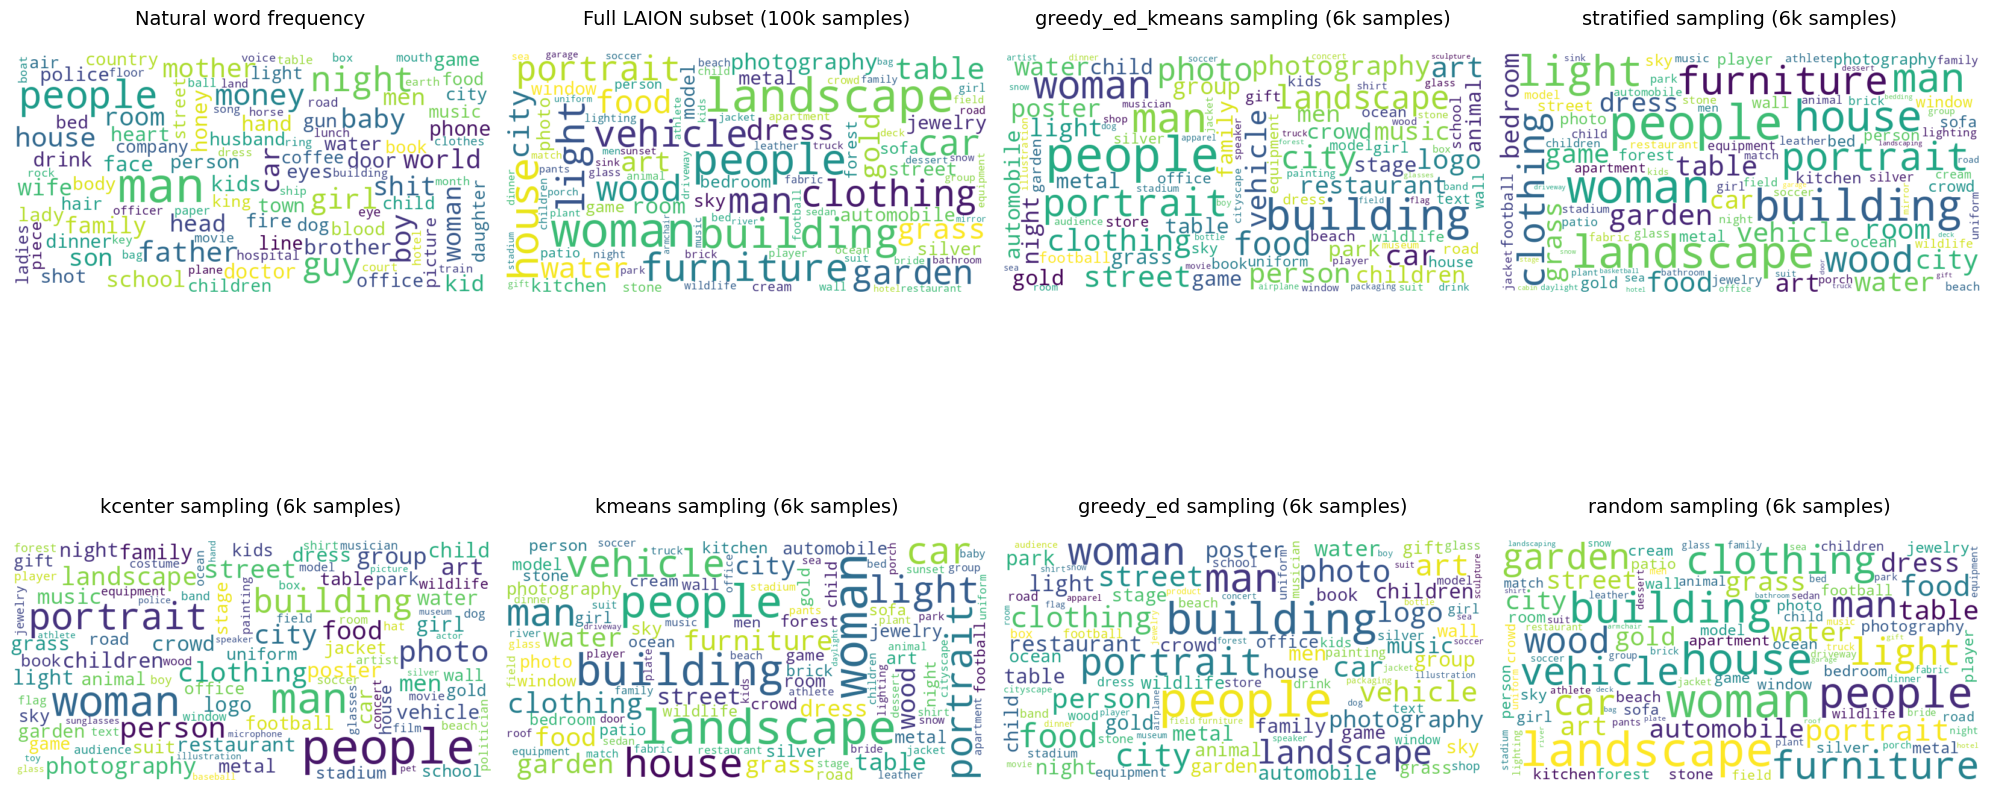

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def create_wordcloud(frequencies, title, ax):
    """Create and plot a wordcloud from word frequencies."""
    # Create wordcloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10,
        max_font_size=80,
    ).generate_from_frequencies(frequencies)

    # Plot
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title, pad=20, size=14)


# Create figure
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

# Prepare raw word frequency distributions
distributions = {
    "Natural word frequency": dict(
        zip(filtered_noun_frequencies["Word"], filtered_noun_frequencies["FREQcount"])
    ),
    "Full LAION subset (100k samples)": dict(baseline_counter),
}

# Add sampling strategies
for strategy, counter in sampling_counters.items():
    distributions[f"{strategy} sampling (6k samples)"] = dict(counter)

# Create wordcloud for each distribution
for idx, (name, freq_dict) in enumerate(distributions.items()):
    # Clean up strategy names for display
    display_name = name if name != "kcenter" else "Core-Set"
    if "sampling: " in display_name:
        display_name = display_name.replace("sampling: ", "")

    create_wordcloud(freq_dict, display_name, axes[idx])

plt.tight_layout()
plt.show()

## t-SNE projection of image features, based on sampling strategy

2025-02-13 11:06:15.747888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 11:06:16.387795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739441176.555101 3436598 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739441176.615831 3436598 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 11:06:17.510809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Computing UMAP embedding for all image features. This may take a moment...


/home/jroth/.conda/envs/edopt/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding computed.


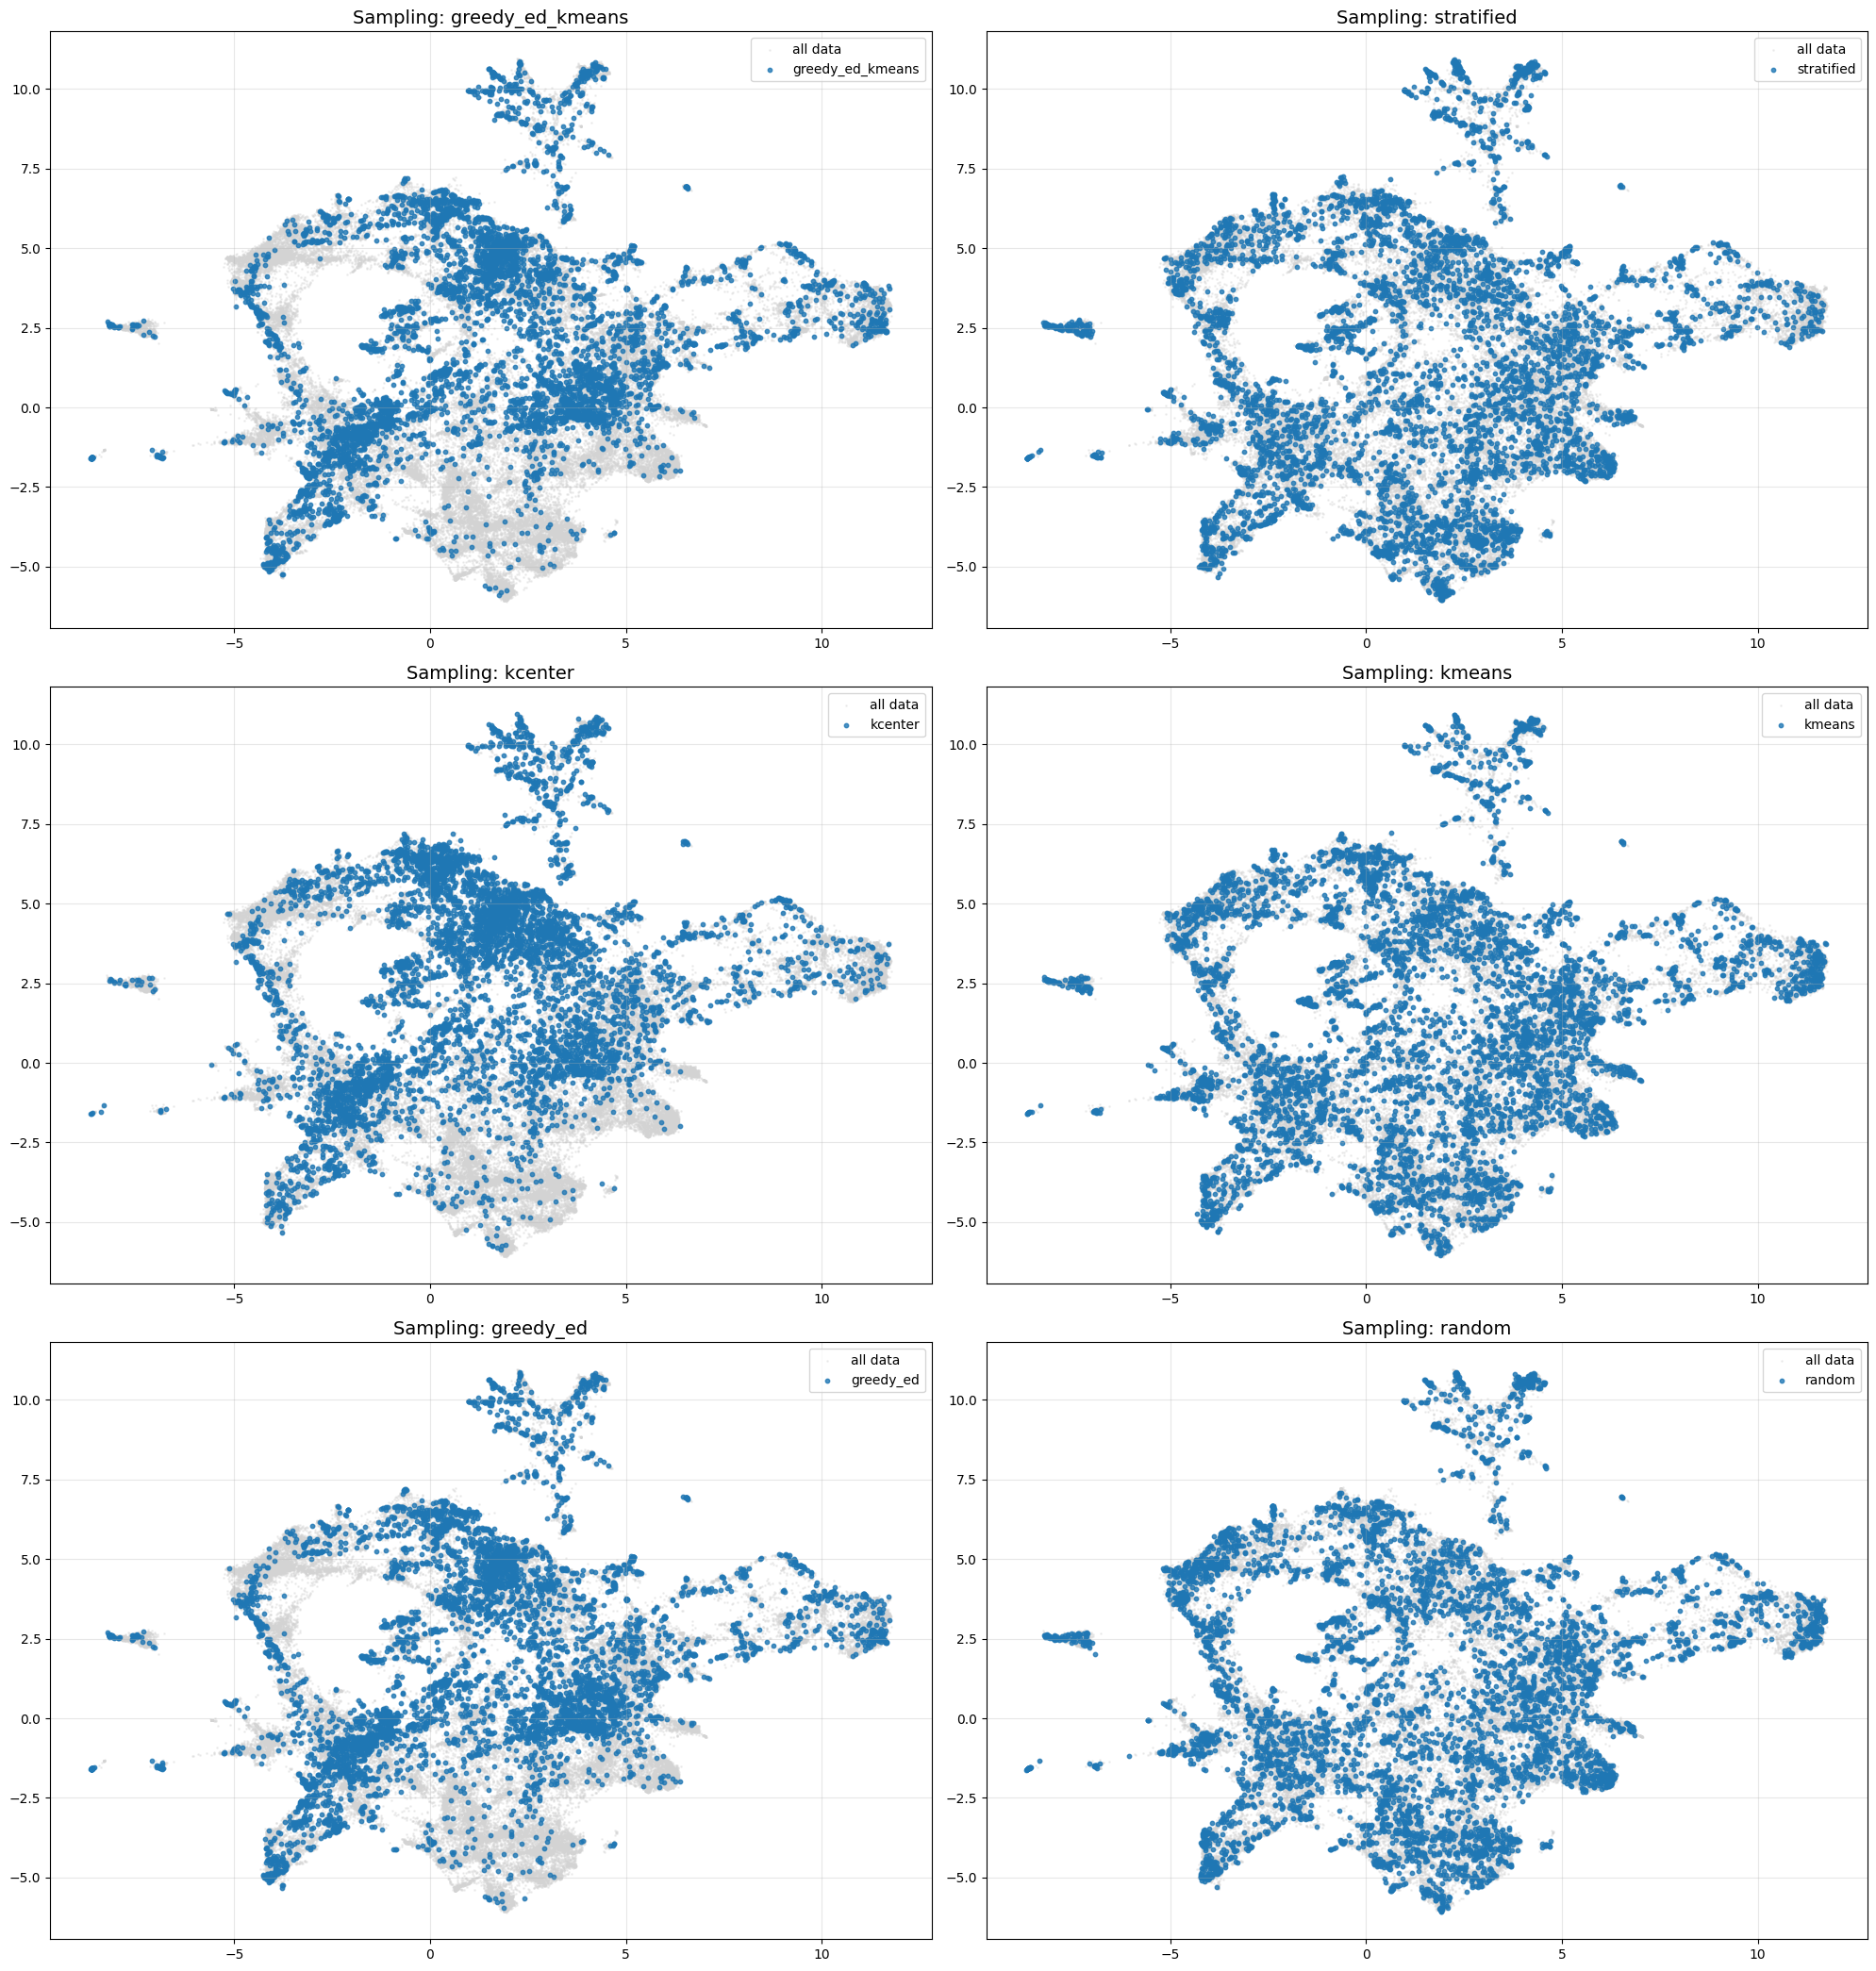

In [71]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Compute UMAP embedding of all image_features
print("Computing UMAP embedding for all image features. This may take a moment...")
reducer = UMAP(n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(image_features)
print("UMAP embedding computed.")

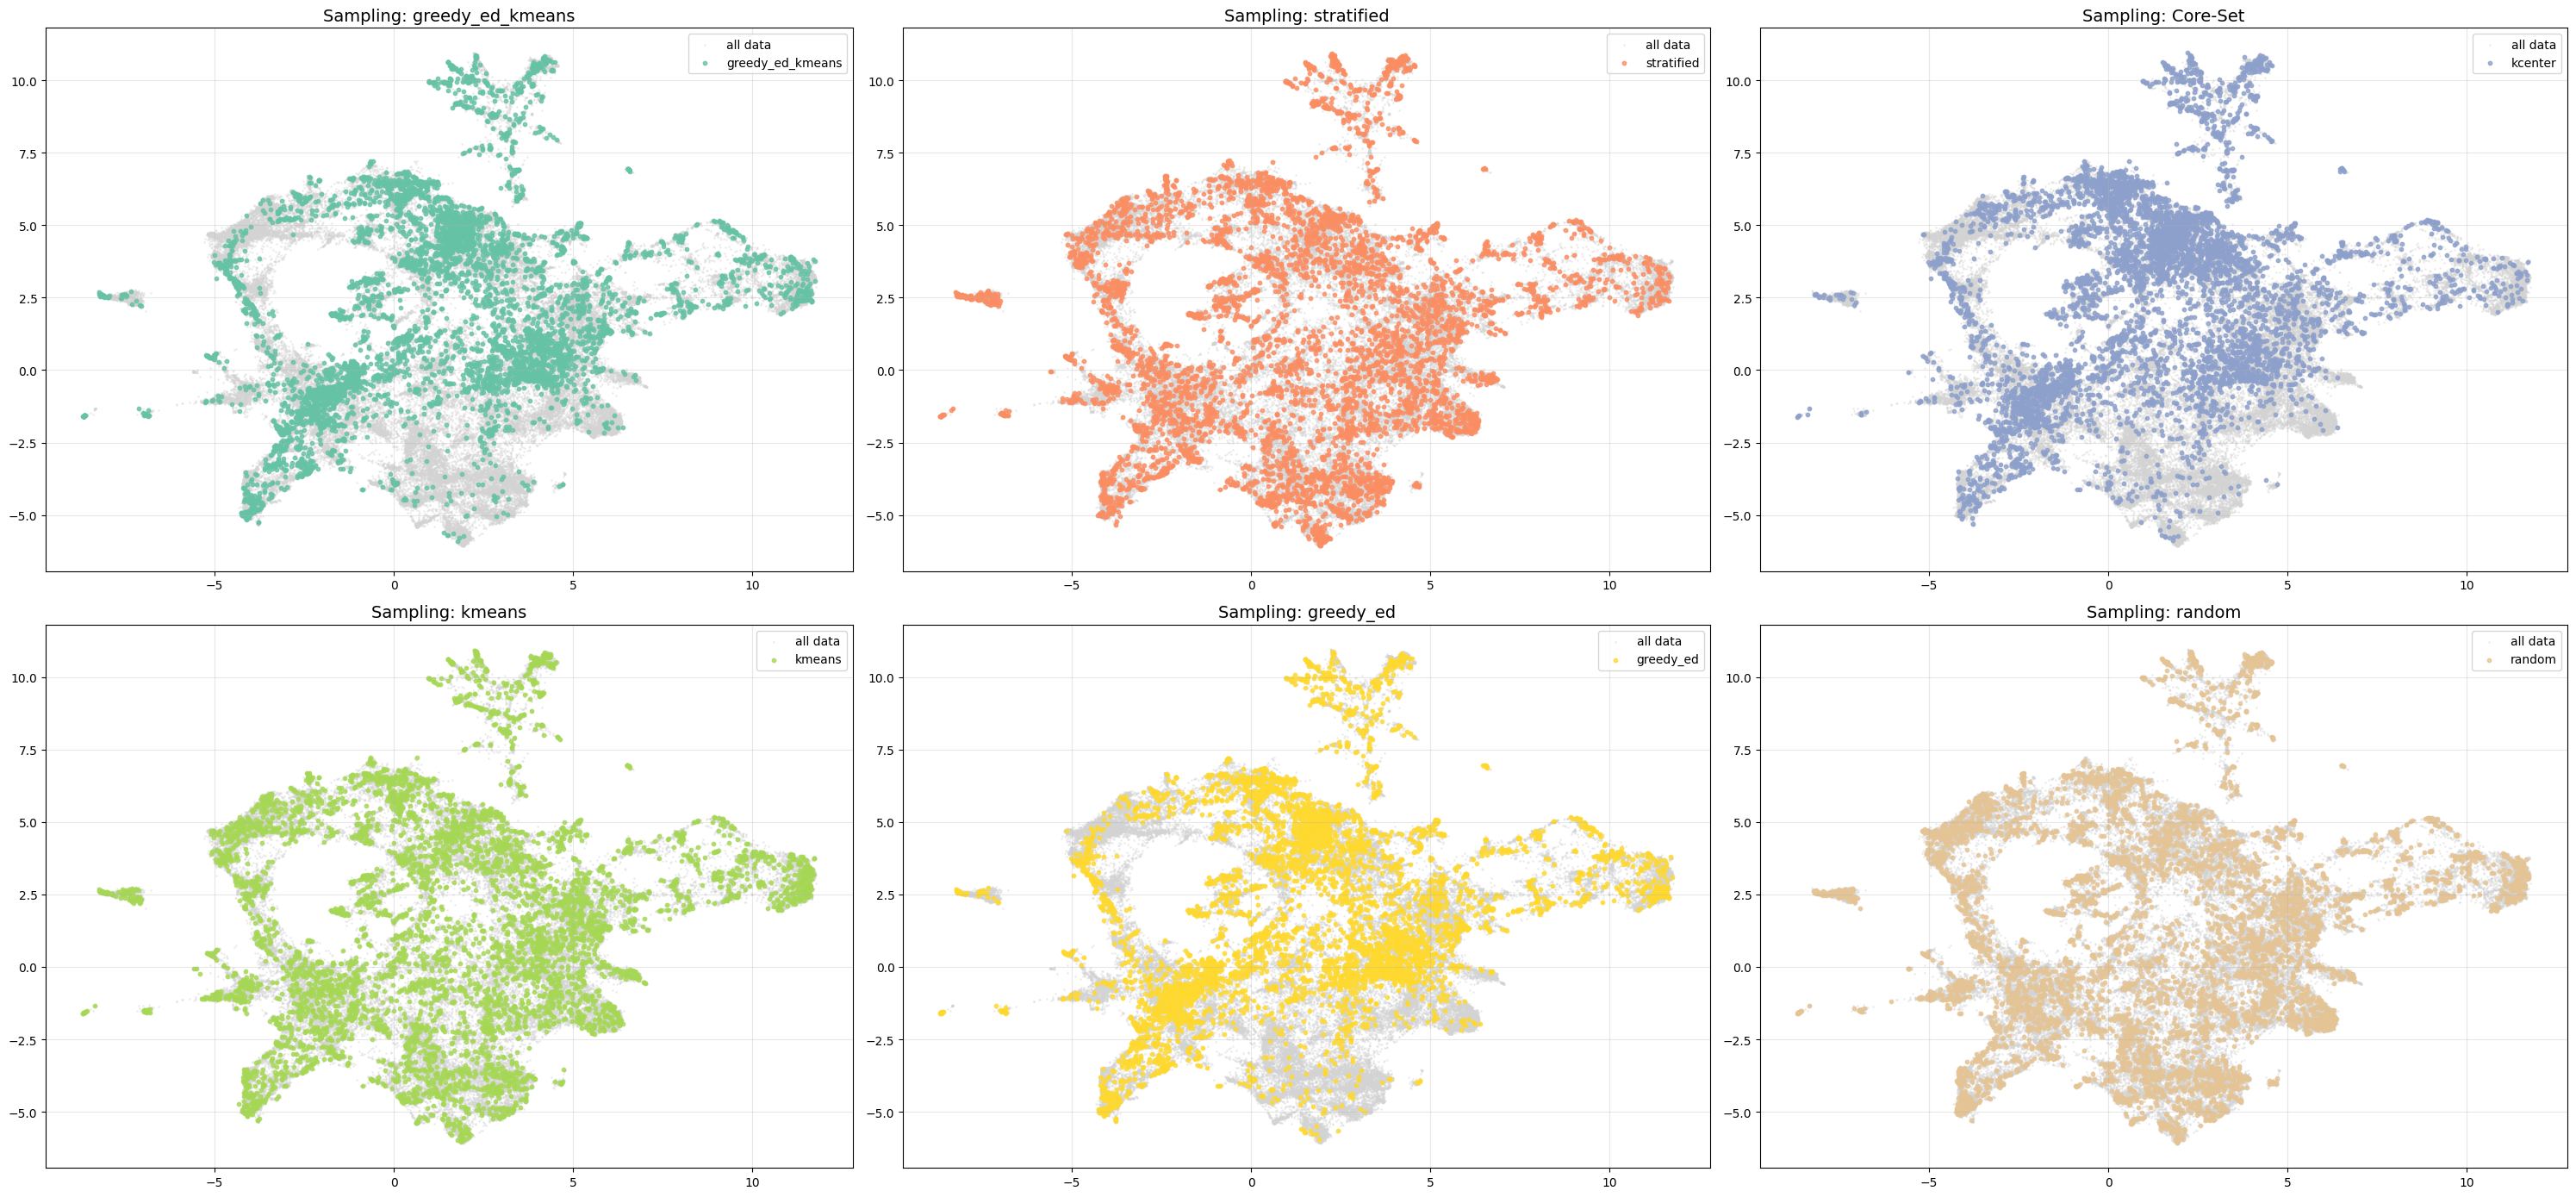

In [ ]:
# Prepare plotting: one subplot per sampling strategy.
strategies = list(sampling_results.keys())
n_strategies = len(strategies)

# Arrange subplots in a grid: use two columns if there are at least two strategies.
n_cols = 3 if n_strategies > 1 else 1
n_rows = (n_strategies + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 7 * n_rows))
if n_strategies == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# For each sampling strategy, plot the full embedding in light gray and overlay the sampled points.
for i, (ax, strat) in enumerate(zip(axes, strategies)):
    # Plot background: all data points in light gray
    ax.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        color="lightgray",
        s=1,
        alpha=0.3,
        label="all data",
    )

    # Extract indices for the sampling strategy and overlay those points
    # Use the same color as in the concept distribution plot (from Set2 colormap)
    indices = sampling_results[strat]
    strat_embedding = umap_embedding[indices, :]
    ax.scatter(
        strat_embedding[:, 0],
        strat_embedding[:, 1],
        s=10,
        alpha=0.8,
        label=f"{strat}",
        color=plt.cm.Set2(i / n_strategies),
    )

    # Update title to match concept distribution plot style
    display_name = strat if strat != "kcenter" else "Core-Set"
    ax.set_title(f"Sampling: {display_name}", fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove any extra axes if there are less strategies than subplots.
for j in range(len(strategies), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Determine keyword count distribution

In [ ]:
def get_keyword_count_dist(subset):
    keyword_counts = [len(subset[idx]) for idx in subset]
    return np.unique(keyword_counts, return_counts=True)


distribution_of_keyword_counts = {}
for strat, indices in sampling_results.items():
    # Construct a subset by filtering image_keywords by indices.
    subset = {
        str(idx): image_keywords[str(idx)]
        for idx in indices
        if str(idx) in image_keywords
    }
    n_keywords, counts = get_keyword_count_dist(subset)
    distribution_of_keyword_counts[strat] = {"n_keywords": n_keywords, "counts": counts}

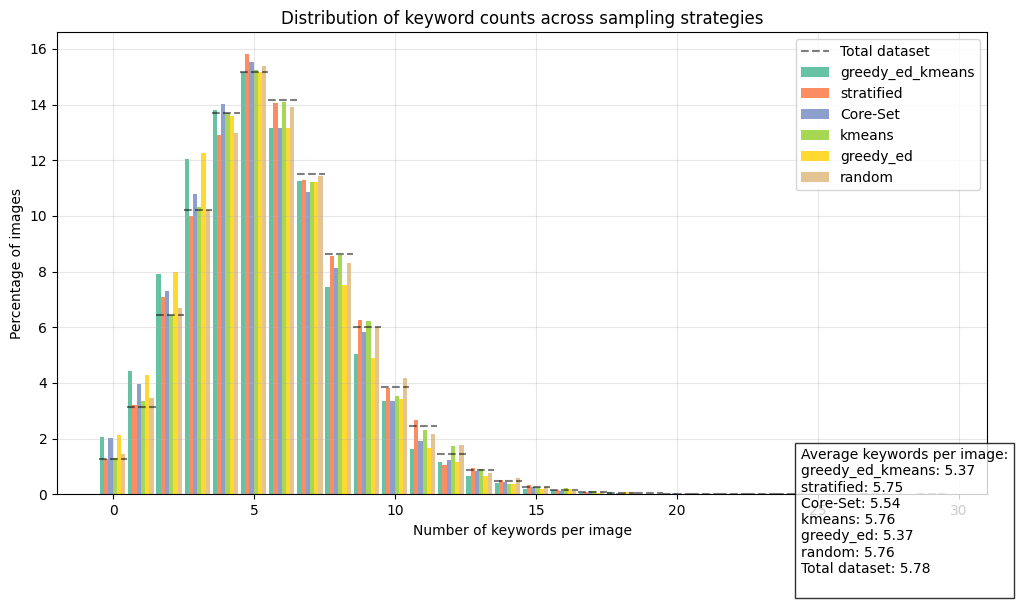

In [ ]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot each sampling strategy's distribution first
strategies = [k for k in distribution_of_keyword_counts.keys() if k != "Total dataset"]
for i, strat in enumerate(strategies):
    data = distribution_of_keyword_counts[strat]
    # Convert to percentages
    total = np.sum(data["counts"])
    percentages = data["counts"] / total * 100

    # Plot with slight offset for better visibility
    offset = i * 0.15
    plt.bar(
        data["n_keywords"] + offset - 0.4,
        percentages,
        width=0.15,
        alpha=1,
        label=strat if strat != "kcenter" else "Core-Set",
        color=plt.cm.Set2(i / len(strategies)),
    )

# Plot total dataset distribution as horizontal lines
total_data = distribution_of_keyword_counts["Total dataset"]
total_percentages = total_data["counts"] / np.sum(total_data["counts"]) * 100

# For each x value (number of keywords), draw a horizontal line
for x, y in zip(total_data["n_keywords"], total_percentages):
    # Extend the line slightly beyond the bars
    plt.hlines(
        y,
        x - 0.5,
        x + 0.5,
        color="black",
        alpha=0.5,
        label="Total dataset" if x == total_data["n_keywords"][0] else "",
        linestyle="--",
        linewidth=1.5,
    )

plt.xlabel("Number of keywords per image")
plt.ylabel("Percentage of images")
plt.title("Distribution of keyword counts across sampling strategies")
plt.legend()
plt.grid(True, alpha=0.3)

# Add summary statistics as text
text = "Average keywords per image:\n"
for strat, data in distribution_of_keyword_counts.items():
    avg = np.average(data["n_keywords"], weights=data["counts"])
    name = strat if strat != "kcenter" else "Core-Set"
    text += f"{name}: {avg:.2f}\n"

plt.text(
    0.8,
    0.1,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.8),
)

plt.show()

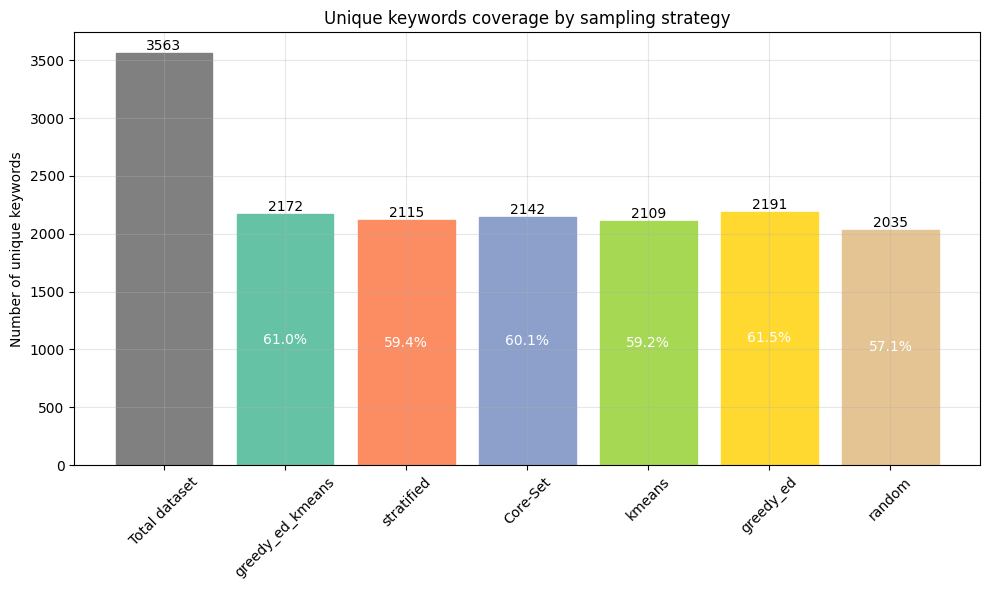

In [125]:
# How many unique keywords are there per sampling strategy?
unique_keywords_per_sampling_strategy = {}

# Get unique keywords for total dataset as baseline
all_keywords = set()
for keywords in image_keywords.values():
    all_keywords.update(keywords)
unique_keywords_per_sampling_strategy["Total dataset"] = len(all_keywords)

# Get unique keywords for each sampling strategy
for strategy, indices in sampling_results.items():
    unique_keywords = set()
    for idx in indices:
        if str(idx) in image_keywords:  # Check if index exists
            unique_keywords.update(image_keywords[str(idx)])
    unique_keywords_per_sampling_strategy[strategy] = len(unique_keywords)

# Create bar plot
plt.figure(figsize=(10, 6))
strategies = list(unique_keywords_per_sampling_strategy.keys())
counts = [unique_keywords_per_sampling_strategy[s] for s in strategies]

# Plot bars
bars = plt.bar(range(len(strategies)), counts)

# Color the bars using the same color scheme as before
for i, bar in enumerate(bars[1:]):  # Skip first bar (Total dataset)
    bar.set_color(plt.cm.Set2((i) / (len(strategies) - 1)))
bars[0].set_color("gray")  # Total dataset in gray

# Customize plot
plt.xticks(
    range(len(strategies)),
    [s if s != "kcenter" else "Core-Set" for s in strategies],
    rotation=45,
)
plt.ylabel("Number of unique keywords")
plt.title("Unique keywords coverage by sampling strategy")
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha="center", va="bottom")

# Add percentage labels relative to total dataset
total = unique_keywords_per_sampling_strategy["Total dataset"]
for i, count in enumerate(counts[1:], 1):  # Skip first bar (Total dataset)
    percentage = (count / total) * 100
    plt.text(
        i,
        count / 2,
        f"{percentage:.1f}%",
        ha="center",
        va="center",
        color="white" if percentage > 20 else "black",
    )

plt.tight_layout()
plt.show()

# Average distance of images to nearest neighbor based on sampling strategy

In [123]:
from scipy.spatial.distance import pdist, squareform
from scipy import stats


def compute_nearest_neighbor_stats(features):
    """
    Compute nearest neighbor distances for a set of features.
    Returns both euclidean and cosine distances.
    """
    # Compute pairwise distances
    euclidean_dist = squareform(pdist(features, metric="euclidean"))
    cosine_dist = squareform(pdist(features, metric="cosine"))

    # For each point, find distance to nearest neighbor
    # Set diagonal to inf to exclude self-distances
    np.fill_diagonal(euclidean_dist, np.inf)
    np.fill_diagonal(cosine_dist, np.inf)

    min_euclidean = np.min(euclidean_dist, axis=1)
    min_cosine = np.min(cosine_dist, axis=1)

    return min_euclidean, min_cosine


# Compute stats for each strategy
nearest_neighbor_stats = {}
for strategy, indices in tqdm(sampling_results.items()):
    features = image_features[indices]
    min_euclidean, min_cosine = compute_nearest_neighbor_stats(features)
    nearest_neighbor_stats[strategy] = {
        "euclidean": min_euclidean,
        "cosine": min_cosine,
    }

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_3436598/3097912359.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax.boxplot(euclidean_data, labels=labels)


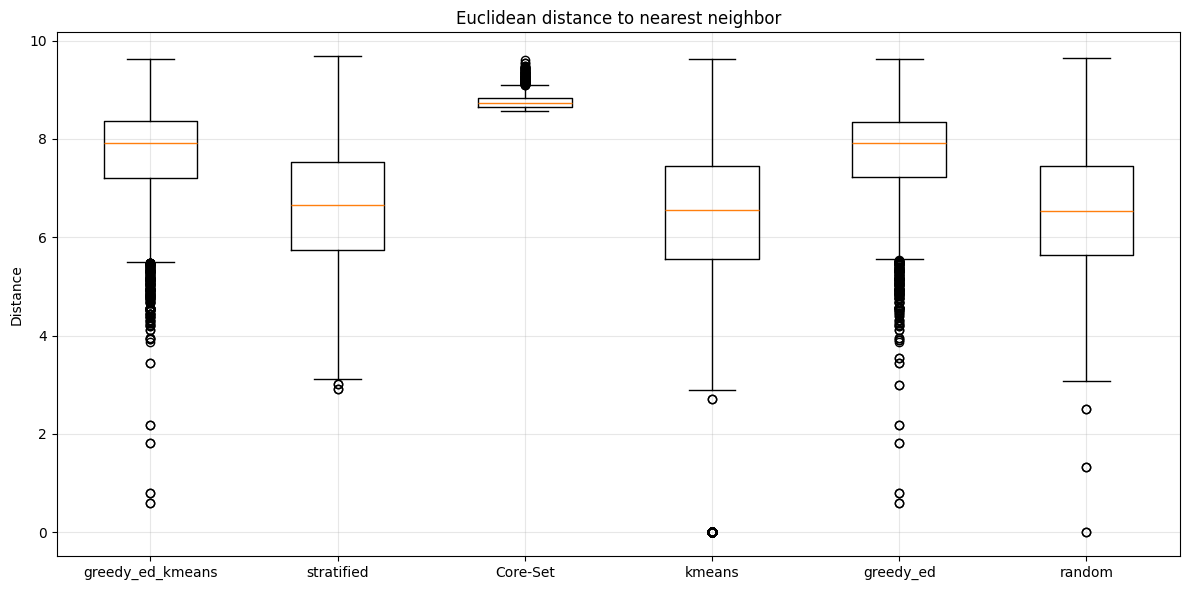

In [124]:
# Create figure with two subplots
fig = plt.figure(figsize=(12, 6))

# Prepare data for box plots
euclidean_data = [stats["euclidean"] for stats in nearest_neighbor_stats.values()]
labels = [
    strat if strat != "kcenter" else "Core-Set"
    for strat in nearest_neighbor_stats.keys()
]

# Plot euclidean distances
ax = fig.add_subplot(1, 1, 1)
bp1 = ax.boxplot(euclidean_data, labels=labels)
ax.set_title("Euclidean distance to nearest neighbor")
ax.set_ylabel("Distance")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
Check KL divergence of 6k subset drawn from natural words 